In [550]:
# Let's create a simple torch model

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

torch.manual_seed(41)

# Define the model
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Define the forward pass in the network
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [551]:
class Stock:
    def __init__(self, name, path = "stocks"):
        self.name = name
        self.df = pd.read_csv(f"{path}/{name}.csv")

    def __str__(self):
        return f'{self.name}'
    
    def simple(self, keep_date = False):
        # remove the date column and Adj Close
        # make a copy
        copied = self.df.copy()
        if not keep_date:
            copied = copied.drop(columns=['Date'])
        copied = copied.drop(columns=['Adj Close'])
        # Drop volume
        copied = copied.drop(columns=['Volume'])
        # Switch the Close and Volume columns
        close = copied.pop("Close")
        # Insert at the end of the dataframe
        copied.insert(len(copied.columns), "Close", close)

        # Add the name of the stock to the columns
        copied.columns = [f'{self.name} {col}' for col in copied.columns]

        return copied
    
    def print_date_range(self):
        print(f"Date range for {self.name}: {self.df['Date'].min()} to {self.df['Date'].max()}")

In [552]:
class StockMarket:
    def __init__(self, stocks):
        self.stocks = stocks

    def __str__(self):
        return f'{self.stocks}'

    def simple(self, keep_date = False):
        # Merge all the stocks
        df = pd.concat([stock.simple(keep_date) for stock in self.stocks], axis=1)

        # Next, return only the overlapping rangers
        # This will get rid of any rows with NaN values
        df = df.dropna()

        # If the dataframe is empty, raise an error
        if df.empty:
            raise ValueError("The dataframe is empty. Choose different stocks that have overlapping ranges")

        return df
    
    def plot(self):
        simple = self.simple()

        # Plot only using the close columns
        simple.filter(like='Close').plot()

    def info(self):
        # Print the start and end date of the simple dataframe
        simple = self.simple(keep_date=True)
        # Get the date using "like"
        start_date = simple.filter(like='Date').iloc[0][0]
        end_date = simple.filter(like='Date').iloc[-1][0]
        print(f"Start date: {start_date}")
        print(f"End date: {end_date}")

In [553]:
Stock("MSFT").print_date_range()

Date range for MSFT: 1986-03-13 to 2020-04-01


In [554]:
Stock("NVDA").print_date_range()

Date range for NVDA: 1999-01-22 to 2020-04-01


In [555]:
Stock("AAPL").print_date_range()

Date range for AAPL: 1980-12-12 to 2020-04-01


In [556]:
Stock("TSM").print_date_range()

Date range for TSM: 1997-10-09 to 2020-04-01


In [557]:
Stock("MSFT").print_date_range()

Date range for MSFT: 1986-03-13 to 2020-04-01


In [558]:
Stock("ORCL").print_date_range()

Date range for ORCL: 1986-03-12 to 2020-04-01


In [559]:
Stock("AMD").print_date_range()

Date range for AMD: 1980-03-17 to 2020-04-01


In [560]:
market = StockMarket([Stock("TSM"), Stock("NVDA"), Stock("AAPL"), Stock("MSFT"), Stock("ORCL"), Stock("AMD")])

In [561]:
market.simple()

,TSM Open,TSM High,TSM Low,TSM Close,NVDA Open,NVDA High,NVDA Low,NVDA Close,AAPL Open,AAPL High,...,MSFT Low,MSFT Close,ORCL Open,ORCL High,ORCL Low,ORCL Close,AMD Open,AMD High,AMD Low,AMD Close
0,5.646040,6.562691,5.646040,6.323565,1.750000,1.953125,1.552083,1.640625,0.513393,0.515625,...,0.088542,0.097222,0.063272,0.064043,0.063272,0.063272,0.000000,3.302083,3.125000,3.145833
1,7.014374,7.040944,6.363419,6.615830,1.770833,1.833333,1.640625,1.812500,0.488839,0.488839,...,0.097222,0.100694,0.064815,0.065586,0.064815,0.064815,0.000000,3.125000,2.937500,3.031250
2,6.629115,6.629115,6.443128,6.469697,1.833333,1.869792,1.645833,1.671875,0.453125,0.453125,...,0.100694,0.102431,0.067130,0.067901,0.067130,0.067130,0.000000,3.083333,3.020833,3.041667
3,6.416558,6.429843,6.031299,6.204001,1.677083,1.718750,1.583333,1.666667,0.462054,0.464286,...,0.098958,0.099826,0.066358,0.066358,0.065586,0.065586,0.000000,3.062500,3.010417,3.010417
4,5.818742,6.044584,5.805458,6.031299,1.666667,1.677083,1.651042,1.661458,0.475446,0.477679,...,0.097222,0.098090,0.064815,0.064815,0.064043,0.064043,0.000000,3.020833,2.906250,2.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5329,37.490002,37.660000,37.189999,37.330002,253.940002,262.220001,250.000000,257.239990,1.557143,1.645714,...,29.940001,29.940001,18.959999,19.290001,18.879999,19.100000,25.000000,29.150000,24.850000,27.850000
5330,36.799999,37.110001,36.529999,36.529999,250.000000,263.119995,248.679993,252.729996,1.636429,1.679286,...,29.900000,30.400000,19.100000,19.150000,18.799999,18.799999,28.860001,29.889999,28.600000,29.010000
5331,36.630001,36.939999,36.119999,36.220001,255.360001,265.959991,253.589996,265.589996,1.635000,1.672857,...,30.299999,30.610001,18.750000,18.820000,18.549999,18.590000,29.000000,29.320000,27.850000,29.000000
5332,36.610001,37.000000,36.610001,36.759998,267.200012,275.399994,257.750000,263.600006,1.671429,1.682143,...,30.530001,30.969999,18.690001,18.980000,18.610001,18.860001,27.799999,27.990000,26.799999,27.600000


Start date: 1997-10-09
End date: 2018-12-19


/tmp/ipykernel_361464/1502648094.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start_date = simple.filter(like='Date').iloc[0][0]
/tmp/ipykernel_361464/1502648094.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end_date = simple.filter(like='Date').iloc[-1][0]


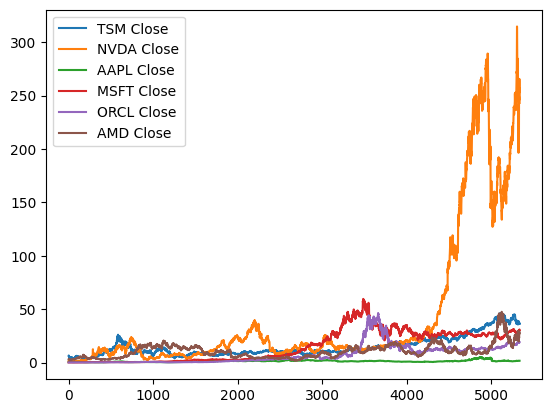

In [562]:
# Graph market.simple()
market.info()
market.plot()

In [563]:
df = market.simple()
number_of_features = len(df.columns) - 1
number_of_features

23

In [564]:
# Split the data into training and testing
# I have chosen to now use the SKLearn train_test_split function because 
# I want to keep the data in order

percent_train = 0.8
percent_test = 1 - percent_train

train_data = df.iloc[:int(len(df) * percent_train)]
test_data = df.iloc[int(len(df) * percent_train):]

In [565]:
# check that the data is split correctly based on df shapes

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Original data shape: {df.shape}")

assert train_data.shape[0] + test_data.shape[0] == df.shape[0]
assert train_data.shape[1] == df.shape[1]

Train data shape: (4266, 24)
Test data shape: (1067, 24)
Original data shape: (5333, 24)


In [566]:
# Finally, split the data into X and y
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]

X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [567]:
X_train

,TSM Open,TSM High,TSM Low,TSM Close,NVDA Open,NVDA High,NVDA Low,NVDA Close,AAPL Open,AAPL High,...,MSFT High,MSFT Low,MSFT Close,ORCL Open,ORCL High,ORCL Low,ORCL Close,AMD Open,AMD High,AMD Low
0,5.646040,6.562691,5.646040,6.323565,1.750000,1.953125,1.552083,1.640625,0.513393,0.515625,...,0.101562,0.088542,0.097222,0.063272,0.064043,0.063272,0.063272,0.0000,3.302083,3.125000
1,7.014374,7.040944,6.363419,6.615830,1.770833,1.833333,1.640625,1.812500,0.488839,0.488839,...,0.102431,0.097222,0.100694,0.064815,0.065586,0.064815,0.064815,0.0000,3.125000,2.937500
2,6.629115,6.629115,6.443128,6.469697,1.833333,1.869792,1.645833,1.671875,0.453125,0.453125,...,0.103299,0.100694,0.102431,0.067130,0.067901,0.067130,0.067130,0.0000,3.083333,3.020833
3,6.416558,6.429843,6.031299,6.204001,1.677083,1.718750,1.583333,1.666667,0.462054,0.464286,...,0.103299,0.098958,0.099826,0.066358,0.066358,0.065586,0.065586,0.0000,3.062500,3.010417
4,5.818742,6.044584,5.805458,6.031299,1.666667,1.677083,1.651042,1.661458,0.475446,0.477679,...,0.100694,0.097222,0.098090,0.064815,0.064815,0.064043,0.064043,0.0000,3.020833,2.906250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,20.700001,20.959999,20.650000,20.920000,33.160000,33.779999,33.070000,33.680000,0.680804,0.687500,...,24.174999,23.514999,23.730000,12.080000,12.480000,11.690000,11.750000,16.8750,17.062500,16.250000
4263,20.879999,20.950001,20.500000,20.520000,33.650002,33.939999,33.380001,33.389999,0.642857,0.649554,...,24.549999,23.730000,24.280001,11.590000,12.180000,11.500000,12.030000,15.9375,16.437500,15.812500
4264,20.430000,20.450001,20.200001,20.360001,33.340000,33.490002,32.959999,32.959999,0.647321,0.656250,...,23.969999,23.440001,23.660000,12.010000,12.140000,11.890000,12.010000,16.0000,16.125000,15.375000
4265,20.290001,20.480000,20.280001,20.340000,32.290001,32.580002,32.040001,32.369999,0.598214,0.647321,...,24.264999,23.365000,23.480000,11.850000,12.130000,11.520000,11.730000,15.8750,16.187500,15.625000


Epoch: 1000 Loss: 0.6277551651000977 Predicted: 7.934744834899902 Actual: 8.56251667461395264
Training complete
Validation: 1016/1016
Accuracy: 0.14271653543307086
Model saved to ./summaries/broker/model.forsyth
Summary saved to ./summaries/broker


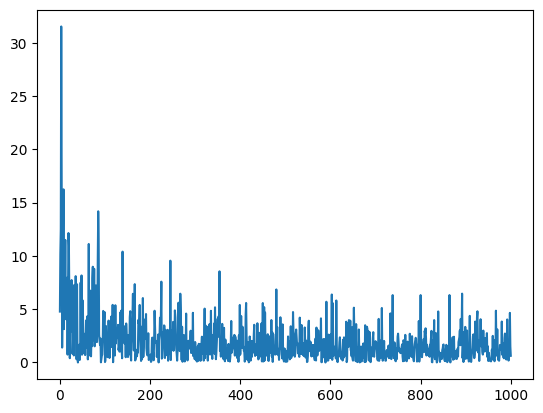

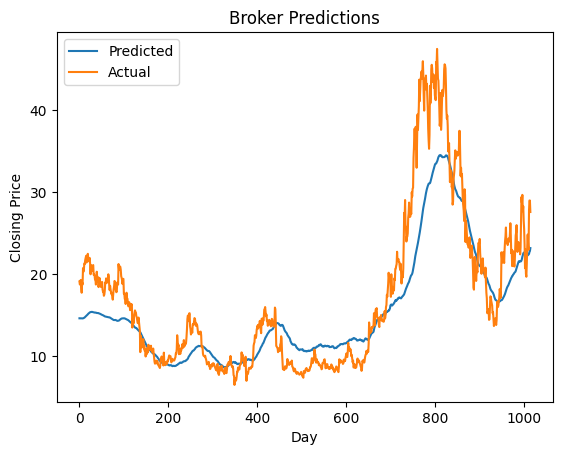

In [568]:
# I want to create a LSTM model that predicts the next day's closing price
# to do this, I intend to take in the previous 5 days' metrics (open, high, low, close, volume)
# and predict the next day's closing price

import os
import sys
from colorama import Fore
import numpy as np

class DynamicModel:
    def __init__(self, number_of_days = 5, number_of_features=5, batch_size = 10, path = None, name = "default_model", hidden_size = 50):

        # Makes it so that the model's input size is the number of features times the number of days
        self.dataset = None
        self.model = SimpleModel(input_size = number_of_features * number_of_days, output_size=1, hidden_size=hidden_size)
        if path:
            self.model.load_state_dict(torch.load(path))
        # self.criterion = nn.MSELoss()
        self.criterion = nn.L1Loss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.number_of_features = number_of_features
        self.number_of_days = number_of_days
        self.batch_size = batch_size
        self.losses = []
        self.predictions = []
        self.name = name

    def info(self):
        print(f"Model: {self.model}")
        print(f"Optimizer: {self.optimizer}")
        print(f"Number of features: {self.number_of_features}")
        print(f"Number of days: {self.number_of_days}")
        print(f"Batch size: {self.batch_size}")

    def get_random_set(self, x_train, y_train):
        # Get a random batch of data
        # This will consider the number of days
        # it should also make sure that whatever index it chooses is not out of bounds

        random_index = np.random.randint(0, len(x_train) - self.number_of_days - 1)

        x_batch = x_train.iloc[random_index:random_index + self.number_of_days]
        # y batch should just be the next day's closing price
        y_batch = y_train.iloc[random_index + self.number_of_days]

        x_batch = torch.tensor(x_batch.values).float().flatten()
        y_batch = torch.tensor(y_batch).float().flatten()

        return x_batch, y_batch


    def train(self, x_train, y_train, epochs):
        # Train the model
        self.losses = []

        for epoch in range(epochs + 1):
            # Get a random batch of data
            x_batch, y_batch = self.get_random_set(x_train, y_train)

            # Forward pass
            y_out = self.model.forward(x_batch)

            # Calculate the loss
            loss = self.criterion(y_out, y_batch)


            self.losses.append(loss.item())

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Print out a comparison of the predicted and actual values every 10 epochs
            if epoch % 10 == 0:
                self.print_inline(f"Epoch: {epoch} Loss: {loss.item()} Predicted: {y_out.item()} Actual: {y_batch.item()}")

        
        print(f"{Fore.GREEN}\nTraining complete{Fore.RESET}")

    def validate(self, x_test, y_test):
        # Validate the model
        # Run the model with the x_test data
        # and compare it to the y_test data

        correct = 0

        for i in range(len(x_test) - self.number_of_days - 1):
            x_batch = x_test.iloc[i:i + self.number_of_days]
            y_batch = y_test.iloc[i + self.number_of_days]

            x_batch = torch.tensor(x_batch.values).float().flatten()
            y_batch = torch.tensor(y_batch).float().flatten()

            y_out = self.model.forward(x_batch).item()

            error = abs(y_out - y_batch) / y_batch
            if error < 0.05:
                correct += 1

            self.predictions.append((y_out, y_batch))

            self.print_inline(f"Validation: {i + 1}/{len(x_test) - self.number_of_days - 1}")
        
        print(f"\nAccuracy: {correct / (len(x_test) - self.number_of_days - 1)}")
        self.accuracy = correct / (len(x_test) - self.number_of_days - 1)
        
    def print_inline(self, string):
        sys.stdout.write("\r" + string)
        sys.stdout.flush()

    def forecast(self, days = 10):
        # Using the model, come up with a forecase for the next n days
        # You will have to recycle your predictions into the model for the next day's prediction
        if (type(self.dataset) == type(None)):
            print(f"{Fore.RED}No dataset found{Fore.RESET}")
            return
        
        # Get the last n days of the dataset. This n should match the model's number of days
        last_n_days = self.dataset.iloc[-self.number_of_days:]
        forecast = []

        for i in range(days):
            x_batch = torch.tensor(last_n_days.values).float().flatten()
            y_out = self.model.forward(x_batch).item()
            forecast.append(y_out)

            # Update the last_n_days
            last_n_days = last_n_days.shift(-1)
            last_n_days.iloc[-1] = y_out

        return forecast
    
    def save(self, path):
        # Save the model to a file
        torch.save(self.model.state_dict(), path)
        print(f"{Fore.GREEN}Model saved to {path}{Fore.RESET}")

    def save_summary(self):
        # Save the model's summary to a folder
        path = f"./summaries/{self.name}"
        os.makedirs(path, exist_ok=True)
        # Save the model
        self.save(f"{path}/model.forsyth")
        # Save a plot of the losses
        plt.figure(1)
        plt.plot(self.losses)
        plt.savefig(f"{path}/loss.png")
        # Save a file with the validation graph with a new plot
        plt.figure(2)
        plt.plot([x[0] for x in self.predictions], label="Predicted")
        plt.plot([x[1] for x in self.predictions], label="Actual")
        plt.title("Broker Predictions")
        plt.xlabel("Day")
        plt.ylabel("Closing Price")
        plt.legend()
        plt.savefig(f"{path}/predictions.png")

        # Save a summary text file
        with open(f"{path}/summary.txt", "w") as f:
            f.write(f"Model: {self.model}\n")
            f.write(f"Optimizer: {self.optimizer}\n")
            f.write(f"Number of features: {self.number_of_features}\n")
            f.write(f"Number of days: {self.number_of_days}\n")
            f.write(f"Accuracy: {self.accuracy}\n")
        print(f"{Fore.GREEN}Summary saved to {path}{Fore.RESET}")
        

Broker = DynamicModel(number_of_days = 50, number_of_features = number_of_features, batch_size = 10, hidden_size = 256, name = "broker")
Broker.train(X_train, y_train, 1000)
Broker.validate(X_test, y_test)
Broker.save_summary()

# Try and Forecast Data

In [569]:
Broker.dataset = X_test
forecast = Broker.forecast(10)

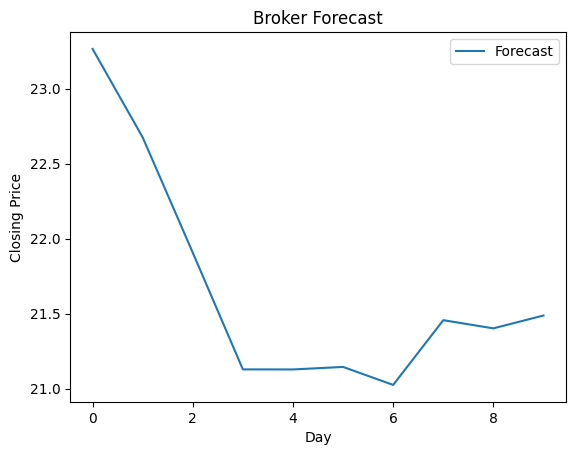

In [570]:
# Graph the broker predictions

plt.plot(forecast, label="Forecast")
plt.title("Broker Forecast")
plt.xlabel("Day")
plt.ylabel("Closing Price")
plt.legend()
plt.show()